In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])
X2 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros(shape=[1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)
Y2 = tf.tanh(tf.matmul(Y1, Wy) + tf.matmul(X2, Wx) + b)

init = tf.global_variables_initializer()

In [17]:
X0_batch = np.array([[1,2,3], [9,8,7], [5,6,8], [4,3,2]])
X1_batch = np.array([[9,8,7], [1,2,3], [6,5,4], [3,2,1]])
X2_batch = np.array([[0,0,0], [0,0,0], [0,0,0], [0,0,0]])

with tf.Session() as sess:
    init.run()
    y0_val, Y1_val, Y2_val = sess.run([Y0, Y1, Y2], feed_dict={X0: X0_batch, X1: X1_batch, X2:X2_batch})

In [18]:
y0_val

array([[ 0.99929804, -0.9999945 ,  0.9999844 ,  0.9992109 ,  0.9716306 ],
       [ 1.        , -1.        ,  1.        ,  0.9999996 ,  0.99951977],
       [ 1.        , -1.        ,  1.        ,  1.        ,  0.9999672 ],
       [ 0.9931387 , -0.99998796,  0.9999995 ,  0.9573313 ,  0.7712016 ]],
      dtype=float32)

In [19]:
Y1_val

array([[ 0.9999997 , -1.        ,  1.        ,  1.        ,  0.9971704 ],
       [ 0.9744227 , -0.9998054 ,  0.97880185,  0.9999802 ,  0.8414157 ],
       [ 0.9989092 , -1.        ,  1.        ,  0.9999898 ,  0.8823123 ],
       [-0.28906715, -0.97954994,  0.86836517,  0.9894863 , -0.36532933]],
      dtype=float32)

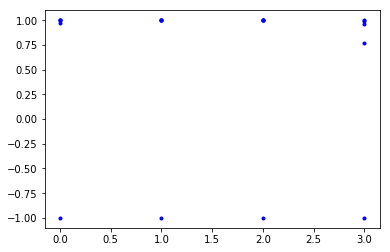

In [20]:
plt.plot(y0_val, 'b.')

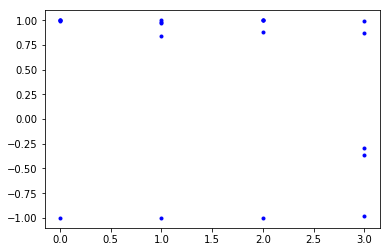

In [21]:
plt.plot(Y1_val, 'b.')

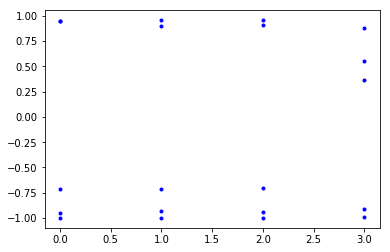

In [22]:
plt.plot(Y2_val, 'b.')

In [23]:
np.var(Y1_val, axis=1)

array([0.6395485 , 0.6105812 , 0.62319964, 0.5799316 ], dtype=float32)

In [24]:
np.var(Y2_val, axis=1)

array([0.8169144 , 0.7949105 , 0.79965067, 0.60167456], dtype=float32)

Using a static RNN

In [25]:
tf.reset_default_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
Y0, Y1 = output_seqs

In [26]:
init = tf.global_variables_initializer()

In [27]:
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0:X0_batch, X1:X1_batch})
    

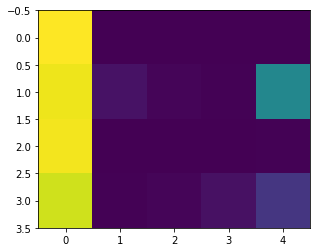

In [28]:
plt.imshow(Y1_val)

In [29]:
tf.reset_default_graph()
n_steps = 2
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
#produce a list of tensors along first dimension
X_seqs = tf.unstack(tf.transpose(X, perm=[1,0,2]))

In [30]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)
#create dimension in tensor and swap dimensions back to original form
outputs = tf.transpose(tf.stack(output_seqs), perm=[1,0,2])

In [31]:
#dynamic unrolling
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

In [32]:
tf.reset_default_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

# basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = n_neurons)
# outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

n_neurons=100
n_layers = 3

cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cel, input_keep_prob=0.50) for cel in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [33]:
init = tf.global_variables_initializer()
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data')
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [34]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        acc_train = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        acc_test = accuracy.eval(feed_dict={X:X_test, y:y_test})
        print(epoch, acc_train, acc_test)

0 0.73333335 0.8229
1 0.84 0.8886


KeyboardInterrupt: 

In [ ]:
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cells_drop, X, dtype=tf.float32)


In [ ]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()


In [ ]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [ ]:
n_iterations = 150
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
        print(mse)

In [36]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [37]:
words = fetch_words_data()

In [43]:
from collections import Counter

vocabulary_size = 50000
vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)

In [44]:
vocabulary = np.array([word for word, _ in vocabulary])

In [57]:
vocabulary[0:100]

array(['UNK', 'the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine',
       'two', 'is', 'as', 'eight', 'for', 's', 'five', 'three', 'was',
       'by', 'that', 'four', 'six', 'seven', 'with', 'on', 'are', 'it',
       'from', 'or', 'his', 'an', 'be', 'this', 'which', 'at', 'he',
       'also', 'not', 'have', 'were', 'has', 'but', 'other', 'their',
       'its', 'first', 'they', 'some', 'had', 'all', 'more', 'most',
       'can', 'been', 'such', 'many', 'who', 'new', 'used', 'there',
       'after', 'when', 'into', 'american', 'time', 'these', 'only',
       'see', 'may', 'than', 'world', 'i', 'b', 'would', 'd', 'no',
       'however', 'between', 'about', 'over', 'years', 'states', 'people',
       'war', 'during', 'united', 'known', 'if', 'called', 'use', 'th',
       'system', 'often', 'state', 'so', 'history', 'will', 'up', 'while'],
      dtype='<U28')

In [58]:
dictionary = {word:code for code,word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [71]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [73]:
data_index = 0
batch, labels = generate_batch(8, 2, 1)

array([[  12],
       [5234],
       [3081],
       [   6],
       [  12],
       [ 195],
       [   2],
       [   6]])